In [ ]:
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.2 MB/s eta 0:00:00


In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import numpy as np
from torchvision.utils import make_grid
import torchvision.models as models
import matplotlib.patches as patches
import gradio as gr
from pathlib import Path

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
### ONLY FOR MAC!!!
#import torch.multiprocessing as mp
#if __name__ == '__main__':
   # mp.set_start_method('spawn')


In [ ]:
# from google.colab import files

# # Upload the kaggle.json file
# uploaded = files.upload()

# # Move kaggle.json to the correct directory
# os.makedirs('/root/.kaggle', exist_ok=True)
# os.rename('kaggle.json', '/root/.kaggle/kaggle.json')

# os.chmod('/root/.kaggle/kaggle.json', 600)

In [ ]:
os.environ['KAGGLE_USERNAME'] = 'username'
os.environ['KAGGLE_KEY'] = 'key'

In [ ]:
# RUN ON NEW ENVIRONMENT ONLY!!!
!kaggle datasets download sujaymann/handwritten-english-characters-and-digits
!unzip handwritten-english-characters-and-digits.zip

Streaming output truncated to the last 5000 lines.
  inflating: augmented_images/augmented_images1/s/s.045.2.augmented.png  
  inflating: augmented_images/augmented_images1/s/s.045.3.augmented.png  
  inflating: augmented_images/augmented_images1/s/s.045.4.augmented.png  
  inflating: augmented_images/augmented_images1/s/s.045.5.augmented.png  
  inflating: augmented_images/augmented_images1/s/s.046.1.augmented.png  
  inflating: augmented_images/augmented_images1/s/s.046.2.augmented.png  
  inflating: augmented_images/augmented_images1/s/s.046.3.augmented.png  
  inflating: augmented_images/augmented_images1/s/s.046.4.augmented.png  
  inflating: augmented_images/augmented_images1/s/s.046.5.augmented.png  
  inflating: augmented_images/augmented_images1/s/s.048.1.augmented.png  
  inflating: augmented_images/augmented_images1/s/s.048.2.augmented.png  
  inflating: augmented_images/augmented_images1/s/s.048.3.augmented.png  
  inflating: augmented_images/augmented_images1/s/s.048.4.aug

In [ ]:

class RandomChoice(torch.nn.Module):
    """Randomly applies one of the given transforms with given probability"""
    def __init__(self, transforms, p=0.5):
        super().__init__()
        self.transforms = transforms
        self.p = p

    def forward(self, img):
        if random.random() < self.p:
            transform = random.choice(self.transforms)
            return transform(img)
        return img


In [ ]:
class ThicknessTransform:
    def __init__(self, kernel_range=(1, 3), p=0.5):
        self.kernel_range = kernel_range
        self.p = p

    def __call__(self, img):
        if torch.rand(1) < self.p:
            # Convert PIL image to numpy array
            img_np = np.array(img)

            # Randomly choose operation (erosion or dilation)
            operation = np.random.choice(['erode', 'dilate'])

            # Random kernel size
            kernel_size = np.random.randint(self.kernel_range[0], self.kernel_range[1] + 1)
            kernel = np.ones((kernel_size, kernel_size), np.uint8)

            # Apply morphological operation
            if operation == 'erode':
                processed = cv2.erode(img_np, kernel, iterations=1)
            else:
                processed = cv2.dilate(img_np, kernel, iterations=1)

            # Convert back to PIL
            return Image.fromarray(processed)
        return img


In [ ]:

class HandwritingDataPipeline:
    def __init__(self, data_root, image_size=64, batch_size=32,
                 train_ratio=0.7, val_ratio=0.15, test_ratio=0.15,
		         seed=42, device='mps', do_transform=False):
        self.device = device
        self.image_size = image_size
        self.batch_size = batch_size
        self.seed = seed

        # Set random seeds
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)

        if do_transform:
            # Define transforms with enhanced augmentations
            self.transform_train = transforms.Compose([
                transforms.Grayscale(num_output_channels=1),
                transforms.Resize((64, 64)),

                # Thickness variations through morphological operations
                ThicknessTransform(kernel_range=(1, 3), p=0.3),

                # Blur variations to simulate different pen pressures
                transforms.RandomApply([
                    transforms.GaussianBlur(3, sigma=(0.1, 0.2))
                ], p=0.3),

                # Conservative rotations
                transforms.RandomRotation(15, fill=255),

                # Gentle affine transformations
                transforms.RandomAffine(
                    degrees=0,
                    translate=(0.1, 0.1),
                    scale=(0.8, 1.2),
                    shear=10,
                    fill=255
                ),

                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
                transforms.RandomErasing(p=0.2, scale=(0.02, 0.03), value=1.0)
            ])
        else:
            self.transform_train = transforms.Compose([
                transforms.Grayscale(num_output_channels=1),  # Convert to grayscale if needed
                transforms.Resize((image_size, image_size)),  # Resize to standard size
                transforms.ToTensor(),  # Convert to tensor
                transforms.Normalize((0.5,), (0.5,))  # Normalize between -1 and 1
            ])

        self.transform_eval = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

        # Load and split dataset
        self.setup_datasets(data_root, train_ratio, val_ratio, test_ratio)

    def setup_datasets(self, data_root, train_ratio, val_ratio, test_ratio):
        """Set up and split datasets with appropriate transforms"""
        # Same as before...
        assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-9, "Ratios must sum to 1"

        full_dataset = datasets.ImageFolder(root=data_root, transform=self.transform_eval)

        total_size = len(full_dataset)
        train_size = int(train_ratio * total_size)
        val_size = int(val_ratio * total_size)
        test_size = total_size - train_size - val_size

        lengths = [train_size, val_size, test_size]
        train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
            full_dataset, lengths, generator=torch.Generator().manual_seed(self.seed)
        )

        train_dataset.dataset.transform = self.transform_train

        self.train_loader = DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2,
            pin_memory=True if self.device != 'cpu' else False
        )

        self.val_loader = DataLoader(
            val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2,
            pin_memory=True
        )

        self.test_loader = DataLoader(
            test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2,
            pin_memory=True
        )

        self.sizes = {
            'train': train_size,
            'val': val_size,
            'test': test_size,
            'total': total_size
        }

    def get_loaders(self):
        """Return all three DataLoaders"""
        return self.train_loader, self.val_loader, self.test_loader

    def get_sizes(self):
        """Return the sizes of all splits"""
        return self.sizes

# Usage:
# pipeline = HandwritingDataPipeline(
#     data_root="./content/augmented_images/augmented_images1",
#     image_size=64,
#     batch_size=32,
#     train_ratio=0.7,
#     val_ratio=0.15,
#     test_ratio=0.15
# )

# train_loader, val_loader, test_loader = pipeline.get_loaders()
# sizes = pipeline.get_sizes()

# print(f"Dataset splits: {sizes}")



In [ ]:

def display_augmented_images(train_loader, num_images=5, num_augmentations=3):
    # Get class names from the dataset
    class_to_idx = train_loader.dataset.dataset.class_to_idx
    idx_to_class = {v: k for k, v in class_to_idx.items()}

    # Get random indices from the dataset
    dataset_size = len(train_loader.dataset)
    random_indices = torch.randperm(dataset_size)[:num_images]

    fig = plt.figure(figsize=(15, 3*num_images))

    for i, dataset_idx in enumerate(random_indices):
        # Get the original image and its true label
        original_path = train_loader.dataset.dataset.imgs[train_loader.dataset.indices[dataset_idx]][0]
        true_label = train_loader.dataset.dataset.imgs[train_loader.dataset.indices[dataset_idx]][1]
        class_name = idx_to_class[true_label]

        # Load and process original image
        original_pil = Image.open(original_path).convert('L')
        original_tensor = pipeline.transform_eval(original_pil)

        # Show true original image
        ax = plt.subplot(num_images, num_augmentations + 1, i*(num_augmentations + 1) + 1)
        img_display = original_tensor.cpu().numpy()[0]
        img_display = (img_display * 0.5) + 0.5  # Denormalize
        ax.imshow(img_display, cmap='gray')
        ax.set_title(f'Original (Class: {class_name})')
        ax.axis('off')

        # Show augmented versions
        for j in range(num_augmentations):
            aug_img = pipeline.transform_train(original_pil)

            ax = plt.subplot(num_images, num_augmentations + 1, i*(num_augmentations + 1) + j + 2)
            aug_display = aug_img.cpu().numpy()[0]
            aug_display = (aug_display * 0.5) + 0.5  # Denormalize
            ax.imshow(aug_display, cmap='gray')
            ax.set_title(f'Augmented {j+1} ({class_name})')
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Usage:
# display_augmented_images(train_loader, num_images=16, num_augmentations=8)


In [ ]:


class LetterCNN64(nn.Module):
    def __init__(self, num_classes):
        super(LetterCNN64, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Compute correct flattened size dynamically
        self._to_linear = self._get_conv_output()

        self.fc1 = nn.Linear(self._to_linear, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def _get_conv_output(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 64, 64)  # Updated input size to (1, 64, 64)
            x = self.pool(F.relu(self.conv1(dummy_input)))
            x = self.pool(F.relu(self.conv2(x)))
            x = self.pool(F.relu(self.conv3(x)))
            return x.numel()  # Correct flattened size

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class ImprovedLetterCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedLetterCNN, self).__init__()

        # First conv block
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25)
        )

        # Second conv block
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25)
        )

        # Third conv block
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25)
        )

        # Compute the flattened size dynamically
        self._to_linear = self._get_conv_output()

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(self._to_linear, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def _get_conv_output(self):
        # Helper function to calculate the flattened size
        x = torch.zeros(1, 1, 64, 64)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x.numel()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


class VGG19HandwritingModel(nn.Module):
    def __init__(self, num_classes, device, pretrained=True):
        super(VGG19HandwritingModel, self).__init__()

        # Load pretrained VGG19 and move to device
        vgg19 = models.vgg19(weights=('DEFAULT' if pretrained else None))
        vgg19 = vgg19.to(device)

        # Modify first layer to accept grayscale images
        self.features = vgg19.features
        self.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1).to(device)

        # Custom classifier for our task
        self.classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 1024),
            nn.ReLU(True),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.5),

            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),

            nn.Linear(512, num_classes)
        ).to(device)

        # Initialize weights for the new layers
        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


In [ ]:

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10, save_dir='checkpoints'):
    train_losses, val_losses = [], []
    best_val_acc = 0.0

    os.makedirs(save_dir, exist_ok=True)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation step
        model.eval()
        val_loss = 0.0
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)
        val_acc = 100 * correct / total

        # Step the scheduler with validation loss
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)  # Pass validation loss as metric
            else:
                scheduler.step()

        # Print current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, LR: {current_lr:.6f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                'train_loss': train_loss,
                'val_loss': val_loss,
                'val_acc': val_acc,
            }, os.path.join(save_dir, 'best_model.pth'))
            print(f"Saved best model with validation accuracy: {val_acc:.2f}%")

    # Save final model
    torch.save({
        'epoch': num_epochs-1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_losses[-1],
        'val_loss': val_losses[-1],
        'val_acc': val_acc,
    }, os.path.join(save_dir, 'final_model.pth'))
    print(f"Saved final model at epoch {num_epochs}")

    # Plot training and validation loss
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    return train_losses, val_losses, best_val_acc

# Function to load a saved model
def load_model(model, optimizer, checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'), weights_only=True)
    # checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    val_acc = checkpoint['val_acc']
    print(f"Loaded model from epoch {epoch+1} with validation accuracy: {val_acc:.2f}%")
    return model, optimizer, epoch, val_acc


def test_model(model, test_loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100 * correct / total
    print(f"Test Accuracy: {test_acc:.2f}%")

def freeze_layers(model, num_layers_to_freeze):
    for i, param in enumerate(model.features.parameters()):
        if i < num_layers_to_freeze:
            param.requires_grad = False


In [ ]:
# model = VGG19HandwritingModel(62, "cpu")
# model = load_model(model, optim.Adam(model.parameters(),  lr=1e-3,   weight_decay=1e-4) , "/content/drive/MyDrive/model_checkpoints_vgg/best_model.pth")

Loaded model from epoch 37 with validation accuracy: 87.24%


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

save_dir = 'model_checkpoints'
num_epochs=20
pretrained=False

# Create the data pipeline
pipeline = HandwritingDataPipeline(
    data_root="/content/augmented_images/augmented_images1",
    image_size=64,
    batch_size=32,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    device=device,
    do_transform=True
)

train_loader, val_loader, test_loader = pipeline.get_loaders()
sizes = pipeline.get_sizes()
print(f"Dataset splits: {sizes}")

# display_augmented_images(train_loader, num_images=16, num_augmentations=8)

# Get number of classes and initialize model
num_classes = len(train_loader.dataset.dataset.classes)
model = VGG19HandwritingModel(num_classes=num_classes, device=device, pretrained=pretrained)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0005)

if pretrained:
    # Training configuration
    optimizer = optim.Adam([
        {'params': model.features.parameters(), 'lr': 1e-5},  # Lower learning rate for VGG features
        {'params': model.classifier.parameters(), 'lr': 1e-4}  # Higher learning rate for new layers
    ])

    # Cosine annealing scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=num_epochs,
        eta_min=1e-6
    )
else:
    num_epochs=50
    # Optimizer setup - single learning rate since we're training from scratch
    optimizer = optim.Adam(
        model.parameters(),
        lr=1e-3,  # Higher initial learning rate since we're training from scratch
        weight_decay=1e-4  # L2 regularization to prevent overfitting
    )

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=1e-3,
        epochs=num_epochs,
        steps_per_epoch=len(train_loader),
        pct_start=0.2,  # Percentage of training to reach max_lr
        div_factor=10,  # Initial learning rate will be max_lr/div_factor
        final_div_factor=1e4  # Final learning rate will be max_lr/final_div_factor
    )


Using device: cpu


NameError: name 'ThicknessTransform' is not defined

In [ ]:
####### T R A I N #######
### DO NOT RUN ##########




# Testing with different schedulers:
# 1. Cosine Annealing
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#     optimizer,
#     T_max=num_epochs,
#     eta_min=1e-6
# )

# 2. Step LR
# scheduler = torch.optim.lr_scheduler.StepLR(
#     optimizer,
#     step_size=5,
#     gamma=0.5
# )

# # 3. One Cycle LR
# scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer,
#     max_lr=0.01,
#     epochs=num_epochs,
#     steps_per_epoch=len(train_loader)
# )

# 4. Reduce LR on Plateau:
# optimizer = optim.Adam(model.parameters(), lr=0.000005)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer,
#     mode='min',      # Monitor loss (min) or metrics (max)
#     factor=0.1,      # Reduction factor
#     patience=3,      # Epochs to wait before reducing
#     verbose=True,
#     min_lr=1e-6
# )

# model, optimizer, epoch, val_acc = load_model(
#     model,
#     optimizer,
#     os.path.join(save_dir, 'best_model.pth')
# )

# Train the model
train_model(model,
            train_loader,
            val_loader,
            criterion,
            optimizer,
            scheduler=scheduler,
            num_epochs=num_epochs,
            save_dir=save_dir
)


In [ ]:
# To load the best model:
model, optimizer, epoch, val_acc = load_model(
    model,
    optimizer,
    os.path.join('/content/drive/MyDrive/model_checkpoints_vgg', 'best_model.pth')
)

# Set the model to eval mode to use pre-calcl batch normalization layers
model.eval()

NameError: name 'model' is not defined

In [ ]:
### OPTIONAL: RUN THE MODEL'S TEST - LONG RUNNING!!!
test_model(model, test_loader)

In [ ]:
def prepare_image(image_path):
    """Prepare image for classification."""
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    image = Image.open(image_path)
    image = transform(image)
    return image.unsqueeze(0)  # Add batch dimension

def get_class_labels(data_root):
    """Get class labels from the data directory."""
    class_names = sorted(os.listdir(data_root))
    # Remove any hidden files (like .DS_Store)
    class_names = [c for c in class_names if not c.startswith('.')]
    return class_names


In [ ]:
# Get class labels and number of classes
class_names = get_class_labels('/content/handwritten-english-characters-and-digits/combined_folder/train')
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")

Number of classes: 62


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

image_path = '/content/drive/MyDrive/sample_letters/9.png'
# image_path = '/content/drive/MyDrive/sample_letters/a.png'
# image_path = '/content/drive/MyDrive/sample_letters/k.png'
# image_path = '/content/drive/MyDrive/sample_letters/o.png'
# image_path = '/content/drive/MyDrive/sample_letters/x.png'

# Load and prepare image
image = prepare_image(image_path)
image = image.to(device)

# Make prediction
with torch.no_grad():
    outputs = model(image)
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    predicted_class = torch.argmax(outputs, dim=1).item()
    confidence = probabilities[0][predicted_class].item() * 100

# Print results
print(f"\nClassification Results:")
print(f"Predicted class: {class_names[predicted_class]}")
print(f"Confidence: {confidence:.2f}%")

# Print top 3 predictions
top_k = 3
top_probs, top_classes = torch.topk(probabilities, top_k)
print(f"\nTop {top_k} predictions:")
for i in range(top_k):
    class_idx = top_classes[0][i].item()
    prob = top_probs[0][i].item() * 100
    print(f"{class_names[class_idx]}: {prob:.2f}%")

NameError: name 'model' is not defined

In [ ]:
def load_model_inference(model, checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    # Optionally load other info if needed
    epoch = checkpoint['epoch']
    val_acc = checkpoint['val_acc']
    print(f"Loaded model from epoch {epoch+1} with validation accuracy: {val_acc:.2f}%")
    return model

model = VGG19HandwritingModel(62, "cpu")
# model = load_model_inference(model, "/content/drive/MyDrive/model_checkpoints_vgg/best_model.pth")
model = load_model_inference(model, "/content/drive/MyDrive/model_checkpoints_vgg/best_model_vgg_full_train.pth")

model.eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 88.8MB/s]


Loaded model from epoch 37 with validation accuracy: 87.24%


VGG19HandwritingModel(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), s

In [ ]:
def visualize_letter_extraction(image_path, letters_info):
    """
    Visualize the extracted letters and their bounding boxes

    Args:
        image_path (str): Path to the original image
        letters_info (list): List of tuples containing letter and bounding box
    """
    # Read the original image
    image = cv2.imread(image_path)

    # Create a copy for visualization
    visual = image.copy()

    # Draw bounding boxes
    for letter, bbox in letters_info:
        x, y, w, h = bbox
        cv2.rectangle(visual, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(visual, letter, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

    # Convert to RGB for displaying with matplotlib
    visual_rgb = cv2.cvtColor(visual, cv2.COLOR_BGR2RGB)

    # Create a figure to display the original and processed images
    plt.figure(figsize=(15, 10))

    # Display original image
    plt.subplot(2, 1, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    # Display processed image with bounding boxes
    plt.subplot(2, 1, 2)
    plt.imshow(visual_rgb)
    plt.title('Detected Letters')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Create a grid of extracted letters
    plt.figure(figsize=(15, 5))
    plt.suptitle('Extracted Individual Letters', fontsize=16)

    num_letters = len(letters_info)
    cols = min(10, num_letters)
    rows = (num_letters + cols - 1) // cols

    for i, (letter, bbox) in enumerate(letters_info):
        x, y, w, h = bbox
        letter_img = image[y:y+h, x:x+w]
        letter_img_rgb = cv2.cvtColor(letter_img, cv2.COLOR_BGR2RGB)

        plt.subplot(rows, cols, i + 1)
        plt.imshow(letter_img_rgb)
        plt.title(f"{letter}")
        plt.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

In [ ]:
'''def extract_letters(image_path, output_dir="extracted_letters"):
    """
    Extract individual letters from a handwritten text image

    Args:
        image_path (str): Path to the input image
        output_dir (str): Directory to save extracted letters

    Returns:
        list: List of tuples containing letter and its bounding box (x, y, w, h)
    """
    # Create output directory if it doesn't exist
    Path(output_dir).mkdir(exist_ok=True)

    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Could not read image: {image_path}")

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply thresholding to get binary image
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Configure Tesseract parameters for character recognition
    custom_config = r'--oem 3 --psm 10'  # PSM 10 treats the image as a single character

    # Find contours for possible letters
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours based on size to avoid noise
    min_area = 50  # Adjust based on your image
    letter_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]

    # Sort contours from left to right
    letter_contours = sorted(letter_contours, key=lambda cnt: cv2.boundingRect(cnt)[0])


    transfoms = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

    # Process each contour
    letters_info = []
    for i, contour in enumerate(letter_contours):
        # Get bounding box
        x, y, w, h = cv2.boundingRect(contour)

        # Extract the letter
        letter_image = gray[y:y+h, x:x+w]


        # Save the letter image
        letter_path = os.path.join(output_dir, f"letter_{i}.png")
        cv2.imwrite(letter_path, letter_image)

        letter_image = Image.fromarray(letter_image)
        letter_image = transfoms(letter_image)
        # Use Tesseract to recognize the character
        try:
            with torch.no_grad():

                outputs = model(image)
                detected_char = torch.argmax(outputs, dim=1).item()



            # If no character is detected, use a placeholder
            if not detected_char:
                detected_char = "?"

            # Keep only the first character if multiple are detected
            detected_char = detected_char[0] if len(detected_char) > 0 else "?"

        except Exception as e:
            print(f"Error recognizing letter {i}: {e}")
            detected_char = "?"

        letters_info.append((detected_char, (x, y, w, h)))

    return letters_info'''

def extract_letters_old(image_path, model, idx_to_char, output_dir="extracted_letters"):
    """
    Extract individual letters from a handwritten text image and classify them.

    Args:
        image_path (str): Path to the input image.
        model (torch.nn.Module): Trained handwriting recognition model.
        idx_to_char (dict): Mapping from index to character.
        output_dir (str): Directory to save extracted letters.

    Returns:
        list: List of tuples containing classified letter and its bounding box.
    """
    model.eval()  # Set model to evaluation mode

    # Ensure the output directory exists
    Path(output_dir).mkdir(exist_ok=True)

    # Read and process the image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Could not read image: {image_path}")

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter small contours
    min_area = 50
    letter_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]
    letter_contours = sorted(letter_contours, key=lambda cnt: cv2.boundingRect(cnt)[0])

    # Image transformations
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    letters_info = []
    for i, contour in enumerate(letter_contours):
        x, y, w, h = cv2.boundingRect(contour)
        letter_image = gray[y:y+h, x:x+w]

        # Convert to PIL image and apply transformations
        letter_image = Image.fromarray(letter_image)
        letter_tensor = transform(letter_image).unsqueeze(0)  # Add batch dimension

        # Classify the letter using the model
        with torch.no_grad():
            outputs = model(letter_tensor)
            predicted_idx = torch.argmax(outputs, dim=1).item()
            detected_char = idx_to_char.get(predicted_idx, "?")

        # Save letter image
        letter_path = os.path.join(output_dir, f"letter_{i}.png")
        cv2.imwrite(letter_path, gray[y:y+h, x:x+w])

        letters_info.append((detected_char, (x, y, w, h)))

    return letters_info


In [ ]:
def extract_letters(image_path, model, class_list, output_dir="extracted_letters"):
    """
    Extract individual letters from a handwritten text image and classify them.

    Args:
        image_path (str): Path to the input image.
        model (torch.nn.Module): Trained handwriting recognition model.
        idx_to_char (dict): Mapping from index to character.
        output_dir (str): Directory to save extracted letters.

    Returns:
        list: List of tuples containing classified letter and its bounding box.
    """
    model.eval()  # Set model to evaluation mode

    # Ensure the output directory exists
    Path(output_dir).mkdir(exist_ok=True)

    # Read and process the image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Could not read image: {image_path}")

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter small contours
    min_area = 50
    letter_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]
    letter_contours = sorted(letter_contours, key=lambda cnt: cv2.boundingRect(cnt)[0])

    # Image transformations
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    letters_info = []
    for i, contour in enumerate(letter_contours):
        x, y, w, h = cv2.boundingRect(contour)
        letter_image = gray[y:y+h, x:x+w]

        # Convert to PIL image and apply transformations
        letter_image = Image.fromarray(letter_image)
        letter_tensor = transform(letter_image).unsqueeze(0)  # Add batch dimension

        # Classify the letter using the model
        with torch.no_grad():
            outputs = model(letter_tensor)
            predicted_idx = torch.argmax(outputs, dim=1).item()
            detected_char = class_list[predicted_idx]


        # Save letter image
        letter_path = os.path.join(output_dir, f"letter_{i}.png")
        cv2.imwrite(letter_path, gray[y:y+h, x:x+w])

        letters_info.append((detected_char, (x, y, w, h)))

    return letters_info

In [ ]:

def demo():
    """
    Demonstrate the letter extraction on a sample image
    """
    # Extract letters
    print("Extracting letters...")
    # letters_info = extract_letters(image_path)

    # idx_to_char = {0: "A", 1: "B", 2: "C", ..., 25: "Z"}  # Define this based on training
    letters_info = extract_letters("/content/drive/MyDrive/sample_letters/image lets go.png", model, class_names)

    # Print detected letters
    print("Detected letters:")
    for letter, bbox in letters_info:
        print(f"Letter: {letter}, Bounding box: {bbox}")

    # Visualize results
    visualize_letter_extraction(image_path, letters_info)


if __name__ == "__main__":
    demo()

Extracting letters...


NameError: name 'class_names' is not defined

In [ ]:
def extract_letters(image_path, model, class_list, output_dir="extracted_letters", spacing=0):
    """
    Extract individual letters from a handwritten text image and classify them.
    Uses two different thresholding methods:
    1. Inverted OTSU thresholding for contour detection
    2. Non-inverted adaptive thresholding for model input images
    """
    model.eval()  # Set model to evaluation mode

    # Ensure the output directory exists
    Path(output_dir).mkdir(exist_ok=True)

    # Read and process the image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Could not read image: {image_path}")

    # Visualize original image
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.savefig(f"{output_dir}/1_original.png")
    plt.show()

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Visualize grayscale image
    plt.figure(figsize=(10, 5))
    plt.imshow(gray, cmap='gray')
    plt.title("Grayscale Image")
    plt.savefig(f"{output_dir}/2_grayscale.png")
    plt.show()

    # Apply OTSU thresholding (inverted) for contour detection
    _, binary_contours = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # Visualize binary image for contour detection
    plt.figure(figsize=(10, 5))
    plt.imshow(binary_contours, cmap='gray')
    plt.title("Binary Image for Contours (Inverted OTSU)")
    plt.savefig(f"{output_dir}/3a_binary_contours.png")
    plt.show()

    _, binary_model = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # binary_model = cv2.adaptiveThreshold(
    #     gray,
    #     255,
    #     cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    #     cv2.THRESH_BINARY,
    #     11,  # Block size
    #     2    # C constant (subtracted from mean)
    # )
    # Visualize binary image for model input
    plt.figure(figsize=(10, 5))
    plt.imshow(binary_model, cmap='gray')
    plt.title("Binary Image for Model Input (Non-inverted Adaptive)")
    plt.savefig(f"{output_dir}/3b_binary_model.png")
    plt.show()

    # Find contours on the inverted binary image (for contour detection)
    contours, _ = cv2.findContours(binary_contours, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Visualize contours
    contour_img = image.copy()
    cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB))
    plt.title(f"All Contours Found: {len(contours)}")
    plt.savefig(f"{output_dir}/4_all_contours.png")
    plt.show()

    # Filter small contours
    min_area = 50
    letter_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]
    print(f"Found {len(contours)} total contours, {len(letter_contours)} after filtering by min area {min_area}")

    # Visualize filtered contours
    filtered_contour_img = image.copy()
    cv2.drawContours(filtered_contour_img, letter_contours, -1, (0, 255, 0), 2)
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(filtered_contour_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Filtered Contours: {len(letter_contours)}")
    plt.savefig(f"{output_dir}/5_filtered_contours.png")
    plt.show()

    # Sort contours from left to right (for reading order)
    letter_contours = sorted(letter_contours, key=lambda cnt: cv2.boundingRect(cnt)[0])

    # Create a figure to show all extracted letters
    num_letters = len(letter_contours)
    fig_rows = max(1, (num_letters + 4) // 5)  # 5 letters per row
    fig_cols = min(5, num_letters)

    plt.figure(figsize=(15, 3 * fig_rows))
    plt.suptitle("Extracted Letters Before Processing", fontsize=16)

    letters_info = []
    model_input_images = []  # Store images that will be fed to the model

    for i, contour in enumerate(letter_contours):
        x, y, w, h = cv2.boundingRect(contour)

        # Extract letter from the ADAPTIVE THRESHOLDED binary image for model input
        # This uses the non-inverted adaptive thresholding for cleaner results
        letter_image = binary_model[y:y+h, x:x+w]

        # Save original extracted letter
        letter_path = os.path.join(output_dir, f"letter_{i}_original.png")
        cv2.imwrite(letter_path, letter_image)

        # Add to the visualization figure
        if i < fig_rows * fig_cols:
            plt.subplot(fig_rows, fig_cols, i + 1)
            plt.imshow(letter_image, cmap='gray')
            plt.title(f"Letter {i}")
            plt.axis('off')

        # Convert to PIL image
        letter_image_pil = Image.fromarray(letter_image)

        # Fix the second issue: Maintain aspect ratio during resize
        # Calculate target size while maintaining aspect ratio
        target_size = 64 - spacing

        # Determine which dimension is larger
        if w > h:
            # Width is the dominant dimension
            new_width = target_size
            new_height = int((h / w) * target_size)
        else:
            # Height is the dominant dimension
            new_height = target_size
            new_width = int((w / h) * target_size)

        # Resize while maintaining aspect ratio
        resized_image = letter_image_pil.resize((new_width, new_height), Image.LANCZOS)

        # Create a new square white image (255 is white for non-inverted binary)
        padded_image = Image.new('L', (target_size, target_size), 255)

        # Calculate padding to center the image
        pad_x = (target_size - new_width) // 2
        pad_y = (target_size - new_height) // 2

        # Paste the resized image at the center
        padded_image.paste(resized_image, (pad_x, pad_y))

        # Save the padded image
        padded_image.save(os.path.join(output_dir, f"letter_{i}_padded.png"))

        # Create the final 64x64 image with the specified spacing
        final_image = Image.new('L', (64, 64), 255)
        spacing_padding = spacing // 2
        final_image.paste(padded_image, (spacing_padding, spacing_padding))

        # Convert to tensor and normalize
        normalize_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

        letter_tensor = normalize_transform(final_image).unsqueeze(0)  # Add batch dimension

        # Save the tensor representation
        transformed_image = letter_tensor[0].cpu().numpy()
        # Denormalize for visualization (undo normalization)
        transformed_image = (transformed_image * 0.5 + 0.5) * 255
        transformed_image = transformed_image[0].astype(np.uint8)  # Just take the first channel

        # Save the final processed image that will be fed to the model
        cv2.imwrite(os.path.join(output_dir, f"letter_{i}_model_input.png"), transformed_image)
        model_input_images.append(transformed_image)

        # Classify the letter using the model
        with torch.no_grad():
            outputs = model(letter_tensor)
            predicted_idx = torch.argmax(outputs, dim=1).item()
            detected_char = class_list[predicted_idx]
            confidence = torch.softmax(outputs, dim=1)[0][predicted_idx].item()
            print(f"Letter {i}: Classified as '{detected_char}' with confidence {confidence:.2f}")

        letters_info.append((detected_char, (x, y, w, h)))

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Make room for the suptitle
    plt.savefig(f"{output_dir}/6_extracted_letters.png")
    plt.show()

    # Visualize the final processed images that are fed to the model
    plt.figure(figsize=(15, 3 * fig_rows))
    plt.suptitle("Processed Images Fed to Model (64x64 with spacing)", fontsize=16)

    for i, img in enumerate(model_input_images):
        if i < fig_rows * fig_cols:
            ax = plt.subplot(fig_rows, fig_cols, i + 1)

            # Display the grayscale image
            plt.imshow(img, cmap='gray')

            # Add a red border around the full 64x64 image
            rect_outer = patches.Rectangle((0, 0), 63, 63, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect_outer)

            # Add a blue border around the inner area
            inner_size = 64 - spacing - 1
            spacing_half = spacing // 2
            rect_inner = patches.Rectangle((spacing_half, spacing_half), inner_size, inner_size,
                                          linewidth=1, edgecolor='b', facecolor='none')
            ax.add_patch(rect_inner)

            plt.title(f"Letter {i}: {letters_info[i][0]}")
            plt.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f"{output_dir}/7_model_inputs_with_border.png")
    plt.show()

    # Draw bounding boxes on original image
    result_img = image.copy()
    for i, (char, (x, y, w, h)) in enumerate(letters_info):
        cv2.rectangle(result_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(result_img, char, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.title("Final Result with Classifications")
    plt.savefig(f"{output_dir}/8_final_result.png")
    plt.show()

    return letters_info


Extracting letters...


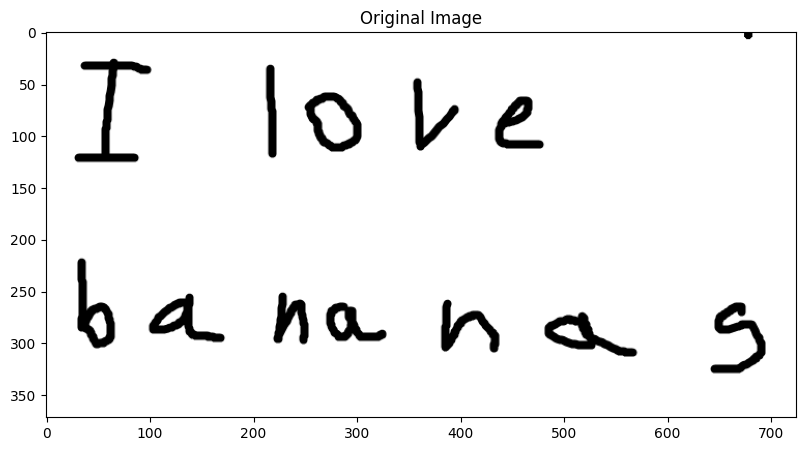

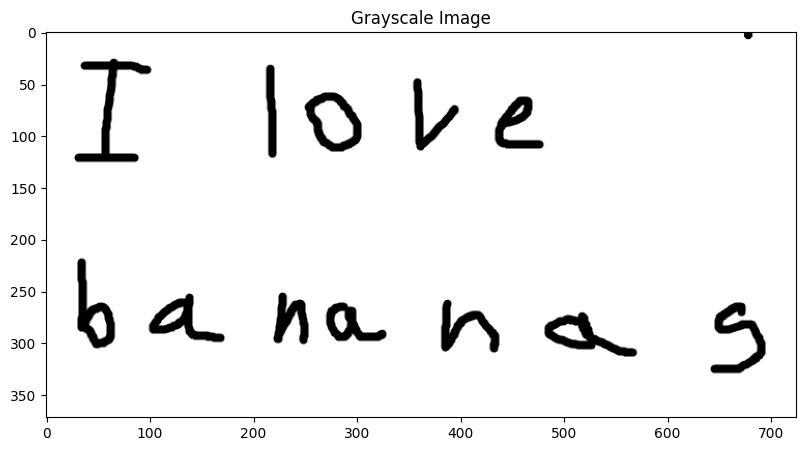

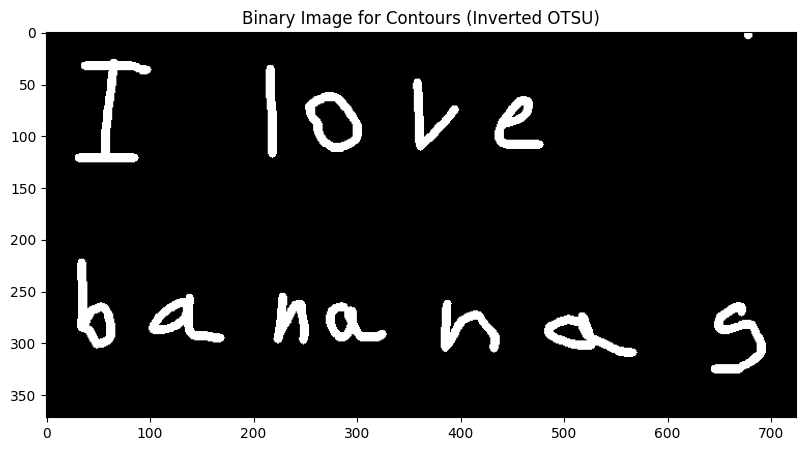

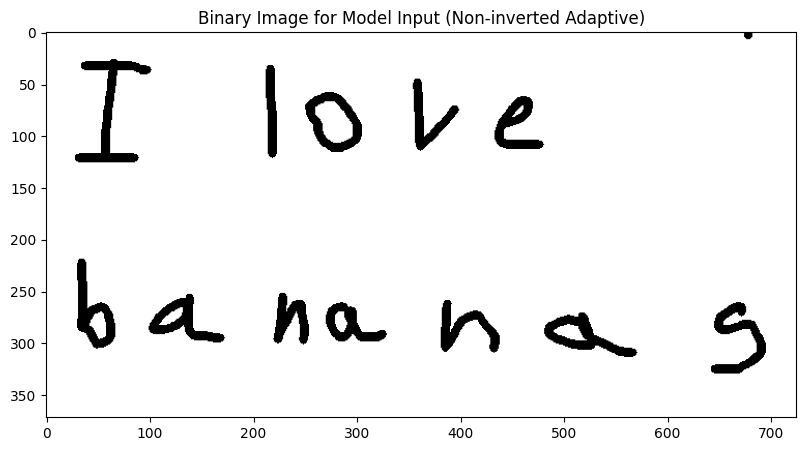

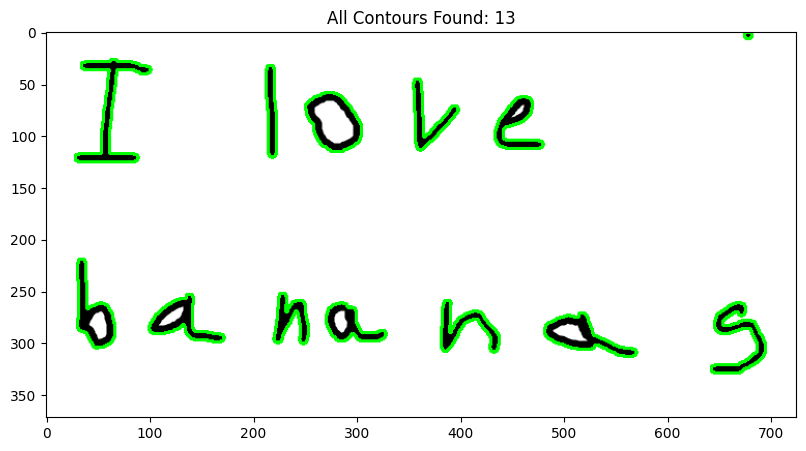

Found 13 total contours, 12 after filtering by min area 50


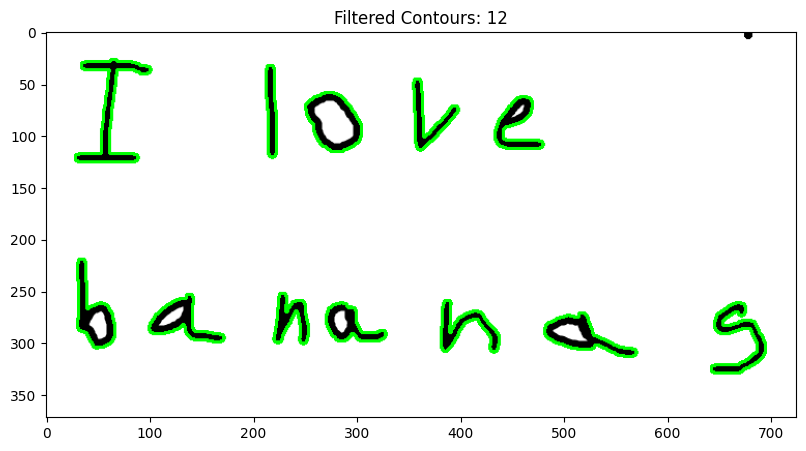

Letter 0: Classified as 'I_caps' with confidence 0.94
Letter 1: Classified as 'b' with confidence 0.92
Letter 2: Classified as 'a' with confidence 0.90
Letter 3: Classified as 'I_caps' with confidence 0.55
Letter 4: Classified as 'm' with confidence 0.42
Letter 5: Classified as 'D_caps' with confidence 0.94
Letter 6: Classified as 'a' with confidence 0.99
Letter 7: Classified as 'V_caps' with confidence 0.82
Letter 8: Classified as 'w' with confidence 0.60
Letter 9: Classified as 'e' with confidence 0.98
Letter 10: Classified as 'a' with confidence 0.52
Letter 11: Classified as 'S_caps' with confidence 0.94


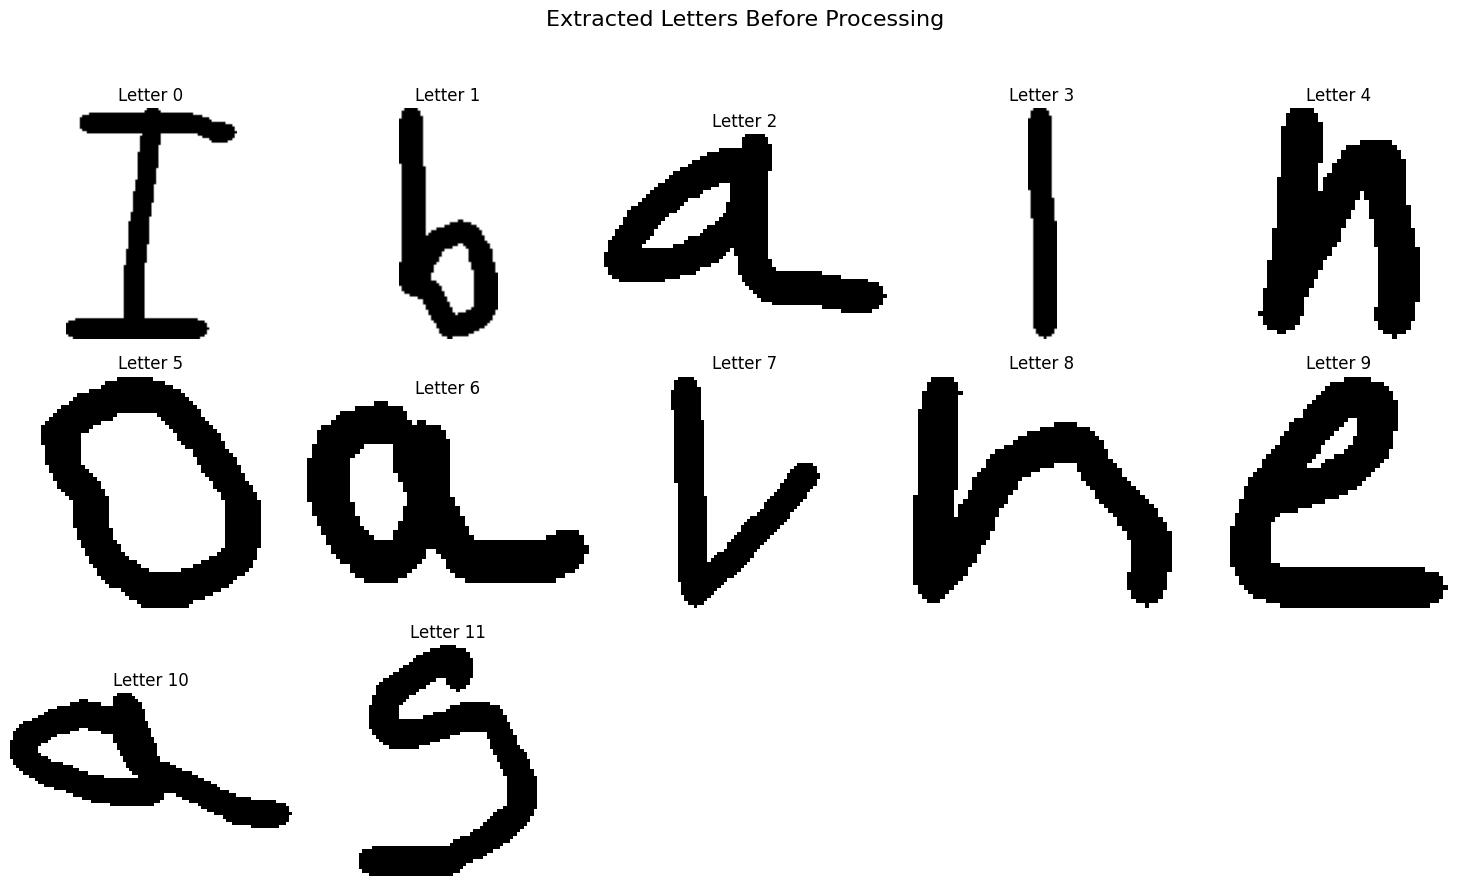

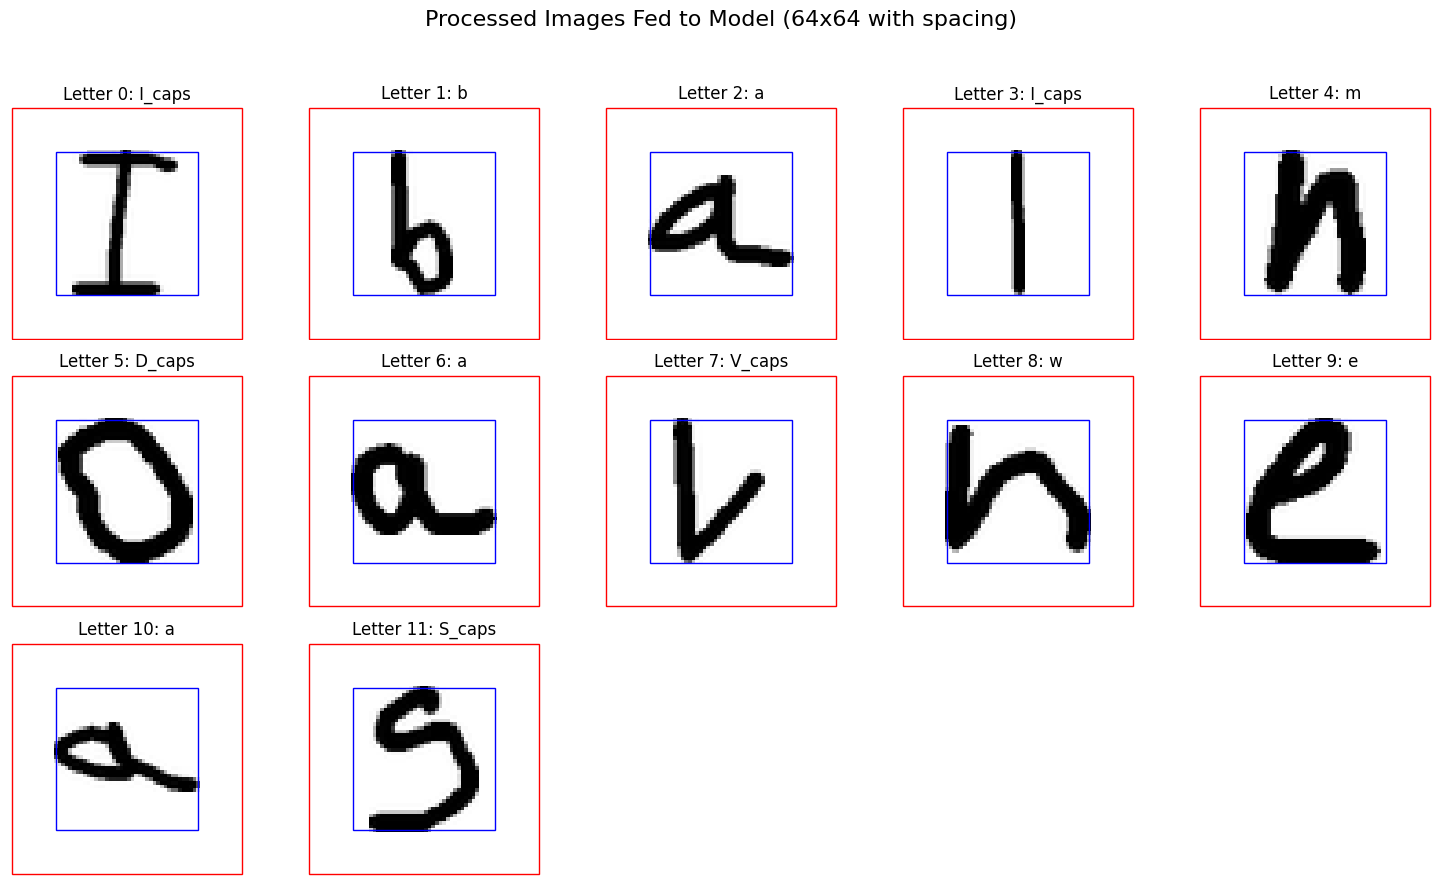

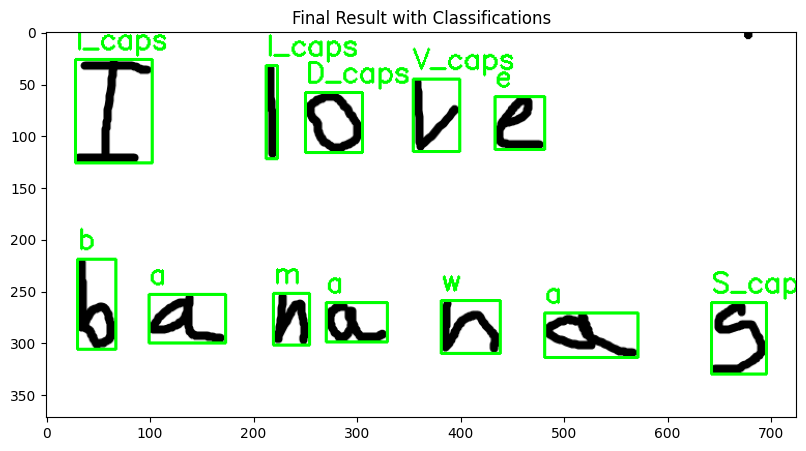

Detected letters:
Letter: I_caps, Bounding box: (28, 26, 74, 100)
Letter: b, Bounding box: (30, 219, 37, 87)
Letter: a, Bounding box: (99, 253, 74, 47)
Letter: I_caps, Bounding box: (212, 32, 11, 90)
Letter: m, Bounding box: (219, 252, 35, 50)
Letter: D_caps, Bounding box: (250, 58, 55, 58)
Letter: a, Bounding box: (270, 261, 59, 38)
Letter: V_caps, Bounding box: (354, 45, 45, 70)
Letter: w, Bounding box: (381, 259, 57, 51)
Letter: e, Bounding box: (433, 62, 48, 51)
Letter: a, Bounding box: (481, 271, 90, 43)
Letter: S_caps, Bounding box: (642, 261, 53, 69)


In [ ]:
def demo():
    """
    Demonstrate the letter extraction on a sample image
    """
    # Extract letters
    print("Extracting letters...")

    image_path = "/content/drive/MyDrive/sample_letters/here_we_go.jpg"
    image_path = "/content/drive/MyDrive/sample_letters/20250331_193146.jpg"
    image_path = "/content/drive/MyDrive/sample_letters/20250331_230539.jpg"
    image_path = "/content/drive/MyDrive/sample_letters/‏‏לכידה.PNG"

    letters_info = extract_letters(image_path, model, class_names, spacing=24)

    # Print detected letters
    print("Detected letters:")
    for letter, bbox in letters_info:
        print(f"Letter: {letter}, Bounding box: {bbox}")

    # If you have a separate visualization function
    # visualize_letter_extraction(image_path, letters_info)
if __name__ == "__main__":
    demo()

In [ ]:


def process_drawn_image(image, model, class_list, spacing=24):
    """
    Process a drawn image from Gradio and extract/classify letters
    """
    output_dir = "extracted_letters"
    Path(output_dir).mkdir(exist_ok=True)

    # Convert gradio image (RGB numpy array) to BGR for OpenCV compatibility
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Create a list to store all the visualization images
    visualization_images = []

    # 1. Original Image
    orig_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    visualization_images.append(("Original Image", orig_img))

    # 2. Grayscale conversion
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    visualization_images.append(("Grayscale Image", gray))

    # 3a. Binary image for contour detection
    _, binary_contours = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    visualization_images.append(("Binary Image for Contours (Inverted OTSU)", binary_contours))

    # 3b. Binary image for model input
    _, binary_model = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    visualization_images.append(("Binary Image for Model Input", binary_model))

    # 4. Find contours
    contours, _ = cv2.findContours(binary_contours, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_img = image.copy()
    cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)
    contour_img_rgb = cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB)
    visualization_images.append((f"All Contours Found: {len(contours)}", contour_img_rgb))

    # 5. Filter small contours
    min_area = 50
    letter_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]
    filtered_contour_img = image.copy()
    cv2.drawContours(filtered_contour_img, letter_contours, -1, (0, 255, 0), 2)
    filtered_contour_img_rgb = cv2.cvtColor(filtered_contour_img, cv2.COLOR_BGR2RGB)
    visualization_images.append((f"Filtered Contours: {len(letter_contours)}", filtered_contour_img_rgb))

    # Sort contours from left to right
    letter_contours = sorted(letter_contours, key=lambda cnt: cv2.boundingRect(cnt)[0])

    # Process each letter
    letters_info = []
    letter_images = []
    model_input_images = []

    # Set model to evaluation mode
    model.eval()

    for i, contour in enumerate(letter_contours):
        x, y, w, h = cv2.boundingRect(contour)

        # Extract letter from binary image
        letter_image = binary_model[y:y+h, x:x+w]
        letter_images.append((f"Letter {i}", letter_image))

        # Convert to PIL image
        letter_image_pil = Image.fromarray(letter_image)

        # Maintain aspect ratio during resize
        target_size = 64 - spacing

        if w > h:
            new_width = target_size
            new_height = int((h / w) * target_size)
        else:
            new_height = target_size
            new_width = int((w / h) * target_size)

        # Resize while maintaining aspect ratio
        resized_image = letter_image_pil.resize((new_width, new_height), Image.LANCZOS)

        # Create a new square white image
        padded_image = Image.new('L', (target_size, target_size), 255)

        # Calculate padding to center the image
        pad_x = (target_size - new_width) // 2
        pad_y = (target_size - new_height) // 2

        # Paste the resized image at the center
        padded_image.paste(resized_image, (pad_x, pad_y))

        # Create the final 64x64 image with specified spacing
        final_image = Image.new('L', (64, 64), 255)
        spacing_padding = spacing // 2
        final_image.paste(padded_image, (spacing_padding, spacing_padding))

        # Convert to tensor and normalize
        normalize_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

        letter_tensor = normalize_transform(final_image).unsqueeze(0)  # Add batch dimension

        # Save the processed image for visualization
        transformed_image = letter_tensor[0].cpu().numpy()
        transformed_image = (transformed_image * 0.5 + 0.5) * 255
        transformed_image = transformed_image[0].astype(np.uint8)
        model_input_images.append((f"Letter {i} Model Input", transformed_image))

        # Classify the letter using the model
        with torch.no_grad():
            outputs = model(letter_tensor)
            predicted_idx = torch.argmax(outputs, dim=1).item()
            detected_char = class_list[predicted_idx]
            confidence = torch.softmax(outputs, dim=1)[0][predicted_idx].item()

        letters_info.append((detected_char, confidence, (x, y, w, h)))

    # Create final result image with classifications
    result_img = image.copy()
    detected_text = ""

    for i, (char, confidence, (x, y, w, h)) in enumerate(letters_info):
        cv2.rectangle(result_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(result_img, f"{char} ({confidence:.2f})", (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        detected_text += char

    result_img_rgb = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
    visualization_images.append(("Final Result with Classifications", result_img_rgb))

    # Combine all letter images and model inputs into group images for better display
    letter_grid = create_image_grid([img for _, img in letter_images], f"Extracted Letters ({len(letter_images)})")
    model_input_grid = create_image_grid([img for _, img in model_input_images],
                                         f"Model Input Images ({len(model_input_images)})")

    if letter_grid is not None:
        visualization_images.append(("Extracted Letters", letter_grid))

    if model_input_grid is not None:
        visualization_images.append(("Model Input Images", model_input_grid))

    return visualization_images, detected_text

def create_image_grid(images, title):
    """Create a grid of images for better visualization"""
    if not images:
        return None

    num_images = len(images)
    cols = min(5, num_images)
    rows = (num_images + cols - 1) // cols

    # Create figure
    plt.figure(figsize=(12, 2 * rows))
    plt.suptitle(title, fontsize=16)

    # Add images to the grid
    for i, img in enumerate(images):
        if i < rows * cols:
            plt.subplot(rows, cols, i + 1)
            plt.imshow(img, cmap='gray')
            plt.title(f"Image {i}")
            plt.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Convert matplotlib figure to image
    fig = plt.gcf()
    fig.canvas.draw()
    grid_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    grid_image = grid_image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close()

    return grid_image

def gradio_interface(model, class_list):
    """Create a Gradio interface for the letter extraction and classification"""

    def process_image(image):
        if image is None:
            return [("No Image Provided", np.zeros((100, 100, 3), dtype=np.uint8))], "No image provided"

        # Process the drawn image
        visualization_images, detected_text = process_drawn_image(image, model, class_list)

        # Return only the images as a list for the gallery
        return [img for _, img in visualization_images], detected_text

    # Define function to handle the sketchpad output
    def process_sketch(sketch):
        # Convert the black and white sketch to a proper image
        if sketch is None:
            return [], "No image drawn"

        # Make sure sketch is 3-channel RGB
        if len(sketch.shape) == 2:
            sketch = np.stack([sketch, sketch, sketch], axis=2)

        return process_image(sketch)

    # Create the interface with the compatible components
    with gr.Blocks(title="Handwritten Letter Recognition") as demo:
        gr.Markdown("# Handwritten Letter Recognition")
        gr.Markdown("Draw letters or a sentence using your mouse, then click 'Process' to recognize the text.")

        with gr.Row():
            with gr.Column(scale=1):
                # For older Gradio versions, use Sketchpad instead of Image with source="canvas"
                input_sketch = gr.Sketchpad( label="Draw Text Here", height = 400, width = 600)

                process_btn = gr.Button("Process")
                clear_btn = gr.Button("Clear")

            with gr.Column(scale=2):
                output_text = gr.Textbox(label="Recognized Text")
                output_gallery = gr.Gallery(
                    label="Processing Steps",
                    show_label=True,
                    columns=2,
                    rows=4,
                    height="auto"
                )

        process_btn.click(fn=process_sketch, inputs=input_sketch, outputs=[output_gallery, output_text])
        clear_btn.click(fn=lambda: None, inputs=None, outputs=input_sketch)

        gr.Markdown("""
        ## How It Works
        1. Draw text using your mouse in the canvas
        2. Click 'Process' to analyze the image
        3. The system will:
           - Convert the image to binary format
           - Find letter contours
           - Extract each letter
           - Process for classification
           - Predict the character for each letter
        4. View all processing steps in the gallery
        """)

    return demo

def launch_interface(model, class_list):
    """Launch the Gradio interface"""
    interface = gradio_interface(model, class_list)
    interface.launch(share=True)


if __name__ == "__main__":
    # Assuming model and class_names are already defined in your code
    launch_interface(model, class_names)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6719384507597e518a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
def process_drawn_image(image, model, class_list, spacing=24):
    """
    Process a drawn image from Gradio and extract/classify letters
    """
    output_dir = "extracted_letters"
    Path(output_dir).mkdir(exist_ok=True)

    # Convert gradio image (RGB numpy array) to BGR for OpenCV compatibility
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Create a list to store all the visualization images
    visualization_images = []

    # 1. Original Image
    orig_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    visualization_images.append(("Original Image", orig_img))

    # 2. Grayscale conversion
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    visualization_images.append(("Grayscale Image", gray))

    # 3a. Binary image for contour detection
    _, binary_contours = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    visualization_images.append(("Binary Image for Contours (Inverted OTSU)", binary_contours))

    # 3b. Binary image for model input
    _, binary_model = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    visualization_images.append(("Binary Image for Model Input", binary_model))

    # 4. Find contours
    contours, _ = cv2.findContours(binary_contours, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_img = image.copy()
    cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)
    contour_img_rgb = cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB)
    visualization_images.append((f"All Contours Found: {len(contours)}", contour_img_rgb))

    # 5. Filter small contours
    min_area = 50
    letter_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]
    filtered_contour_img = image.copy()
    cv2.drawContours(filtered_contour_img, letter_contours, -1, (0, 255, 0), 2)
    filtered_contour_img_rgb = cv2.cvtColor(filtered_contour_img, cv2.COLOR_BGR2RGB)
    visualization_images.append((f"Filtered Contours: {len(letter_contours)}", filtered_contour_img_rgb))

    # Sort contours from left to right
    letter_contours = sorted(letter_contours, key=lambda cnt: cv2.boundingRect(cnt)[0])

    # Process each letter
    letters_info = []
    letter_images = []
    model_input_images = []

    # Set model to evaluation mode
    model.eval()

    for i, contour in enumerate(letter_contours):
        x, y, w, h = cv2.boundingRect(contour)

        # Extract letter from binary image
        letter_image = binary_model[y:y+h, x:x+w]
        letter_images.append((f"Letter {i}", letter_image))

        # Convert to PIL image
        letter_image_pil = Image.fromarray(letter_image)

        # Maintain aspect ratio during resize
        target_size = 64 - spacing

        if w > h:
            new_width = target_size
            new_height = int((h / w) * target_size)
        else:
            new_height = target_size
            new_width = int((w / h) * target_size)

        # Resize while maintaining aspect ratio
        resized_image = letter_image_pil.resize((new_width, new_height), Image.LANCZOS)

        # Create a new square white image
        padded_image = Image.new('L', (target_size, target_size), 255)

        # Calculate padding to center the image
        pad_x = (target_size - new_width) // 2
        pad_y = (target_size - new_height) // 2

        # Paste the resized image at the center
        padded_image.paste(resized_image, (pad_x, pad_y))

        # Create the final 64x64 image with specified spacing
        final_image = Image.new('L', (64, 64), 255)
        spacing_padding = spacing // 2
        final_image.paste(padded_image, (spacing_padding, spacing_padding))

        # Convert to tensor and normalize
        normalize_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

        letter_tensor = normalize_transform(final_image).unsqueeze(0)  # Add batch dimension

        # Save the processed image for visualization
        transformed_image = letter_tensor[0].cpu().numpy()
        transformed_image = (transformed_image * 0.5 + 0.5) * 255
        transformed_image = transformed_image[0].astype(np.uint8)
        model_input_images.append((f"Letter {i} Model Input", transformed_image))

        # Classify the letter using the model
        with torch.no_grad():
            outputs = model(letter_tensor)
            predicted_idx = torch.argmax(outputs, dim=1).item()
            detected_char = class_list[predicted_idx]
            confidence = torch.softmax(outputs, dim=1)[0][predicted_idx].item()

        letters_info.append((detected_char, confidence, (x, y, w, h)))

    # Create final result image with classifications
    result_img = image.copy()
    detected_text = ""

    for i, (char, confidence, (x, y, w, h)) in enumerate(letters_info):
        cv2.rectangle(result_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(result_img, f"{char} ({confidence:.2f})", (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        detected_text += char

    result_img_rgb = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
    visualization_images.append(("Final Result with Classifications", result_img_rgb))

    # Combine all letter images and model inputs into group images for better display
    letter_grid = create_image_grid([img for _, img in letter_images], f"Extracted Letters ({len(letter_images)})")
    model_input_grid = create_image_grid([img for _, img in model_input_images],
                                         f"Model Input Images ({len(model_input_images)})")

    if letter_grid is not None:
        visualization_images.append(("Extracted Letters", letter_grid))

    if model_input_grid is not None:
        visualization_images.append(("Model Input Images", model_input_grid))

    return visualization_images, detected_text

def create_image_grid(images, title):
    """Create a grid of images for better visualization"""
    if not images:
        return None

    num_images = len(images)
    cols = min(5, num_images)
    rows = (num_images + cols - 1) // cols

    # Create figure
    plt.figure(figsize=(12, 2 * rows))
    plt.suptitle(title, fontsize=16)

    # Add images to the grid
    for i, img in enumerate(images):
        if i < rows * cols:
            plt.subplot(rows, cols, i + 1)
            plt.imshow(img, cmap='gray')
            plt.title(f"Image {i}")
            plt.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Convert matplotlib figure to image
    fig = plt.gcf()
    fig.canvas.draw()
    grid_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    grid_image = grid_image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close()

    return grid_image

def launch_interface(model, class_list):
    """Create the most basic compatible interface for older Gradio versions"""

    def process_sketch(sketch):
        # Convert the sketch to a proper image
        if sketch is None:
            return "No image drawn", None

        # Make sure sketch is 3-channel RGB
        if len(sketch.shape) == 2:
            sketch = np.stack([sketch, sketch, sketch], axis=2)

        # Process the drawn image
        visualization_images, detected_text = process_drawn_image(sketch, model, class_list)

        # Combine all images into a single display
        combined_img = create_combined_image(visualization_images)

        return detected_text, combined_img

    def create_combined_image(visualization_images):
        """Create a single image with all visualization steps"""
        # Determine a reasonable layout
        num_images = len(visualization_images)
        cols = min(3, num_images)
        rows = (num_images + cols - 1) // cols

        plt.figure(figsize=(15, 5 * rows))

        for i, (title, img) in enumerate(visualization_images):
            plt.subplot(rows, cols, i + 1)

            # Handle grayscale images
            if len(img.shape) == 2:
                plt.imshow(img, cmap='gray')
            else:
                plt.imshow(img)

            plt.title(title)
            plt.axis('off')

        plt.tight_layout()

        # Convert matplotlib figure to image
        fig = plt.gcf()
        fig.canvas.draw()
        combined_img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        combined_img = combined_img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close()

        return combined_img

    # Create a very basic interface that should work with any Gradio version
    interface = gr.Interface(
        fn=process_sketch,
        inputs=gr.Sketchpad(),
        outputs=[
            gr.Textbox(label="Recognized Text"),
            gr.Image(label="Processing Steps")
        ],
        title="Handwritten Letter Recognition",
        description="Draw letters or a sentence using your mouse, then click submit to recognize the text."
    )

    interface.launch(share=True)


if __name__ == "__main__":
    # Assuming model and class_names are already defined in your code
    launch_interface(model, class_names)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://81d649997ccd16116d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
print(gr.__version__)

5.23.3


In [ ]:


def process_uploaded_image(image, model, class_list, spacing=24):
    """
    Process an uploaded image and extract/classify letters
    """
    # Check if image is None
    if image is None:
        return [], "No image provided"

    output_dir = "extracted_letters"
    Path(output_dir).mkdir(exist_ok=True)

    # Make sure image is in the right format for processing
    # Convert PIL image to numpy if needed
    if not isinstance(image, np.ndarray):
        image = np.array(image)

    # Make sure image is in RGB format
    if len(image.shape) == 2:  # If grayscale
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    elif len(image.shape) == 3 and image.shape[2] == 4:  # If RGBA
        image = image[:, :, :3]  # Drop alpha channel

    # Convert to BGR for OpenCV functions
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Create a list to store all the visualization images
    visualization_images = []

    # 1. Original Image
    orig_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    visualization_images.append(("Original Image", orig_img))

    # 2. Grayscale conversion
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    visualization_images.append(("Grayscale Image", gray))

    # 3a. Binary image for contour detection
    _, binary_contours = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    visualization_images.append(("Binary Image for Contours (Inverted OTSU)", binary_contours))

    # 3b. Binary image for model input
    _, binary_model = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    visualization_images.append(("Binary Image for Model Input", binary_model))

    # 4. Find contours
    contours, _ = cv2.findContours(binary_contours, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_img = image.copy()
    cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)
    contour_img_rgb = cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB)
    visualization_images.append((f"All Contours Found: {len(contours)}", contour_img_rgb))

    # Check if we found any contours
    if len(contours) == 0:
        return visualization_images, "No letters detected"

    # 5. Filter small contours
    min_area = 50
    letter_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]
    filtered_contour_img = image.copy()
    cv2.drawContours(filtered_contour_img, letter_contours, -1, (0, 255, 0), 2)
    filtered_contour_img_rgb = cv2.cvtColor(filtered_contour_img, cv2.COLOR_BGR2RGB)
    visualization_images.append((f"Filtered Contours: {len(letter_contours)}", filtered_contour_img_rgb))

    # Check if we have any letters after filtering
    if len(letter_contours) == 0:
        return visualization_images, "No valid letters detected after filtering"

    # Sort contours from left to right
    letter_contours = sorted(letter_contours, key=lambda cnt: cv2.boundingRect(cnt)[0])

    # Process each letter
    letters_info = []
    letter_images = []
    model_input_images = []

    # Ensure model is available
    if model is None:
        return visualization_images, "Model not loaded"

    # Set model to evaluation mode
    model.eval()

    # Ensure device compatibility
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    for i, contour in enumerate(letter_contours):
        x, y, w, h = cv2.boundingRect(contour)

        # Skip extremely small contours that passed the area filter
        if w < 5 or h < 5:
            continue

        # Extract letter from binary image
        letter_image = binary_model[y:y+h, x:x+w]
        letter_images.append((f"Letter {i}", letter_image))

        # Convert to PIL image
        letter_image_pil = Image.fromarray(letter_image)

        # Maintain aspect ratio during resize
        target_size = 64 - spacing

        if w > h:
            new_width = target_size
            new_height = int((h / w) * target_size)
        else:
            new_height = target_size
            new_width = int((w / h) * target_size)

        # Resize while maintaining aspect ratio
        resized_image = letter_image_pil.resize((new_width, new_height), Image.LANCZOS)

        # Create a new square white image
        padded_image = Image.new('L', (target_size, target_size), 255)

        # Calculate padding to center the image
        pad_x = (target_size - new_width) // 2
        pad_y = (target_size - new_height) // 2

        # Paste the resized image at the center
        padded_image.paste(resized_image, (pad_x, pad_y))

        # Create the final 64x64 image with specified spacing
        final_image = Image.new('L', (64, 64), 255)
        spacing_padding = spacing // 2
        final_image.paste(padded_image, (spacing_padding, spacing_padding))

        # Convert to tensor and normalize
        normalize_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

        letter_tensor = normalize_transform(final_image).unsqueeze(0)  # Add batch dimension
        letter_tensor = letter_tensor.to(device)

        # Save the processed image for visualization
        transformed_image = letter_tensor[0].cpu().numpy()
        transformed_image = (transformed_image * 0.5 + 0.5) * 255
        transformed_image = transformed_image[0].astype(np.uint8)
        model_input_images.append((f"Letter {i} Model Input", transformed_image))

        try:
            # Classify the letter using the model
            with torch.no_grad():
                outputs = model(letter_tensor)
                predicted_idx = torch.argmax(outputs, dim=1).item()
                detected_char = class_list[predicted_idx]
                confidence = torch.softmax(outputs, dim=1)[0][predicted_idx].item()

            letters_info.append((detected_char, confidence, (x, y, w, h)))
        except Exception as e:
            print(f"Error classifying letter {i}: {e}")
            # Continue with next letter instead of failing completely
            continue

    # Create final result image with classifications
    result_img = image.copy()
    detected_text = ""

    for i, (char, confidence, (x, y, w, h)) in enumerate(letters_info):
        cv2.rectangle(result_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(result_img, f"{char} ({confidence:.2f})", (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        detected_text += char

    result_img_rgb = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
    visualization_images.append(("Final Result with Classifications", result_img_rgb))

    # Combine all letter images and model inputs into group images for better display
    if letter_images:
        letter_grid = create_image_grid([img for _, img in letter_images], f"Extracted Letters ({len(letter_images)})")
        if letter_grid is not None:
            visualization_images.append(("Extracted Letters", letter_grid))

    if model_input_images:
        model_input_grid = create_image_grid([img for _, img in model_input_images],
                                            f"Model Input Images ({len(model_input_images)})")
        if model_input_grid is not None:
            visualization_images.append(("Model Input Images", model_input_grid))

    return visualization_images, detected_text

def create_image_grid(images, title):
    """Create a grid of images for better visualization"""
    if not images:
        return None

    num_images = len(images)
    cols = min(5, num_images)
    rows = (num_images + cols - 1) // cols

    # Create figure
    plt.figure(figsize=(12, 2 * rows))
    plt.suptitle(title, fontsize=16)

    # Add images to the grid
    for i, img in enumerate(images):
        if i < rows * cols:
            plt.subplot(rows, cols, i + 1)
            plt.imshow(img, cmap='gray')
            plt.title(f"Image {i}")
            plt.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    try:
        # Convert matplotlib figure to image
        fig = plt.gcf()
        fig.canvas.draw()
        grid_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        grid_image = grid_image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close()
        return grid_image
    except Exception as e:
        print(f"Error creating image grid: {e}")
        plt.close()
        return None

def create_combined_image(visualization_images):
    """Create a single image with all visualization steps"""
    # Check if we have any images
    if not visualization_images:
        # Return empty image
        empty_img = np.ones((300, 500, 3), dtype=np.uint8) * 255
        cv2.putText(empty_img, "No visualization available", (50, 150),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
        return empty_img

    # Determine a reasonable layout
    num_images = len(visualization_images)
    cols = min(3, num_images)
    rows = (num_images + cols - 1) // cols

    try:
        plt.figure(figsize=(15, 5 * rows))

        for i, (title, img) in enumerate(visualization_images):
            plt.subplot(rows, cols, i + 1)

            # Handle grayscale images
            if len(img.shape) == 2:
                plt.imshow(img, cmap='gray')
            else:
                plt.imshow(img)

            plt.title(title)
            plt.axis('off')

        plt.tight_layout()

        # Convert matplotlib figure to image
        fig = plt.gcf()
        fig.canvas.draw()
        combined_img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        combined_img = combined_img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close()

        return combined_img

    except Exception as e:
        print(f"Error creating combined image: {e}")
        plt.close()

        # Return a simple error image instead
        error_img = np.ones((300, 500, 3), dtype=np.uint8) * 255
        cv2.putText(error_img, f"Error: {str(e)}", (50, 150),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        return error_img

def process_image(image, model, class_list):
    """Process the uploaded image and handle potential errors"""
    try:
        if image is None:
            error_img = np.ones((300, 500, 3), dtype=np.uint8) * 255
            cv2.putText(error_img, "No image uploaded", (50, 150),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
            return "No image uploaded", error_img

        # Process the uploaded image
        visualization_images, detected_text = process_uploaded_image(image, model, class_list)

        # Combine all images into a single display
        combined_img = create_combined_image(visualization_images)

        return detected_text, combined_img

    except Exception as e:
        print(f"Error in process_image: {e}")

        # Create error image
        error_img = np.ones((300, 500, 3), dtype=np.uint8) * 255
        cv2.putText(error_img, f"Error: {str(e)}", (50, 150),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        return f"Error: {str(e)}", error_img

def launch_interface(model, class_list):
    """Create a robust interface with image upload that handles errors gracefully"""

    # Create a function that pre-binds the model and class_list
    def process_image_bound(image):
        return process_image(image, model, class_list)

    # Create a user-friendly interface with image upload
    with gr.Blocks() as interface:
        gr.Markdown("# Handwritten Letter Recognition")
        gr.Markdown("Upload an image with handwritten letters to recognize the text.")

        with gr.Row():
            with gr.Column():
                image_input = gr.Image(type="pil", label="Upload Handwritten Image")
                submit_btn = gr.Button("Recognize Text")

                # Add example images if you have any
                example_folder = "example_images"
                if os.path.exists(example_folder):
                    example_images = [os.path.join(example_folder, f) for f in os.listdir(example_folder)
                                     if f.endswith(('.png', '.jpg', '.jpeg'))]
                    if example_images:
                        gr.Examples(examples=example_images, inputs=image_input)

            with gr.Column():
                text_output = gr.Textbox(label="Recognized Text")
                image_output = gr.Image(label="Processing Steps")

        # Add preprocessing options
        with gr.Accordion("Advanced Options", open=False):
            gr.Markdown("These options will be implemented in a future version")
            # Placeholder for future enhancements
            # resize_slider = gr.Slider(minimum=0.1, maximum=2.0, value=1.0, step=0.1, label="Resize Factor")
            # invert_checkbox = gr.Checkbox(label="Invert Image", value=False)

        submit_btn.click(
            fn=process_image_bound,
            inputs=image_input,
            outputs=[text_output, image_output]
        )

        # Also process when the image is uploaded
        image_input.change(
            fn=process_image_bound,
            inputs=image_input,
            outputs=[text_output, image_output]
        )

    # Launch the interface
    interface.launch(share=True)

# Example of how to define class_names if not already defined
# class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
#               'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
#               'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
#               'U', 'V', 'W', 'X', 'Y', 'Z',
#               'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j',
#               'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't',
#               'u', 'v', 'w', 'x', 'y', 'z']

if __name__ == "__main__":
    # Make sure model and class_names are properly defined before launching
    # If they're not defined, you'll need code like this:
    #
    # import torch
    # model = YourModelClass(...)  # Initialize your model
    # model.load_state_dict(torch.load('your_model_path.pth'))
    # class_names = [...]  # Define your class names list

    try:
        launch_interface(model, class_names)
    except NameError as e:
        print(f"Error: {e}. Make sure 'model' and 'class_names' are defined before calling launch_interface.")
        print("Example code:")
        print("model = YourModelClass(...)")
        print("model.load_state_dict(torch.load('your_model_path.pth'))")
        print("class_names = ['A', 'B', 'C', ...] # Your list of characters")
        print("launch_interface(model, class_names)")

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://833f9955466e146537.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
